<center><h1>QBUS6850 - Machine Learning for Business</h1></center>

<center><h1>Advanced Classification Techniques I</h1></center>

**Objectives:**

- To learn how to build Decision Trees;
- To learn how to use decision tree model from scikit;
- To learn how to visualising trees or extract rules

In [ ]:
# node 1: ++++++++++++ # 12/12 # min disorder: entropy min
# node 2: ------------ #  0/12 # min disorder: entropy min
# node 3: ++++++------ #  6/12 # max disordered: entropy max

In [ ]:
# classification
5 samples: 1 + , 4 ----
# regression
5 samples: 1,2,3,4,5 = 3

**Review: Lecture 6**


**Review: tutorial 6**
1. Hard / Soft Margin SVM  
    `from sklearn import svm`  
    `clf = svm.SVC(kernel='linear', C = 0.05)` # soft  
    `clf = svm.SVC(kernel='linear', C = 500)` # (approximate) hard  
    `clf.fit(X, y)`  
    `clf.predict(X)`  
    `margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))`  
    `clf.decision_function`  
    
    
2. SVM with kernel  
    `clf = svm.SVC(kernel = "rbf")`    
    `clf.fit(X, y)`    
    `clf.predict(X)`  


3. Grid Search with CV  
    `param_grid = {'parmaeter': [range], 'parameter': [range]}`   
    `clf = GridSearchCV(model, param_grid)`  
    `clf.fit(X,y)`  
    
    
3. PCA  
    `PCA(n_components).fit(X)`   
    `pca.transform(X)`   

Note: To complete all the tasks in this tutorial, you need install Graphviz and Pydotplus.  See Section-6 for information

## Decision Tree Mechanics<a id='mechanics'></a>

Almost all decision trees algorithms work on the same shared principle. That is, <span class="girk">recursively partition the data to maximise the purity of classes in each partition</span>. Under this principle eventually the leaf nodes (partitions) will be pure or close to pure.

Below we will demonstrate how this principle works in practice through a naive implementation of ID3 that builds a single layer tree i.e. a single root node and two leaf nodes. In such a shallow tree we need only compute one split of the data so we can omit the recursive component.

> ID3 (Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for categorical targets.  
> *from http://scikit-learn.org/stable/modules/tree.html*

Refer to Section `1.10.7. Mathematical formulation` to see the mathematical details that used by Python. 

To build our single layer decision tree we only need to calculate one partition. This partition should yield the purest partition. In the case of categorical features this is easy, we can produce $N$ candidate splits where $N$ is the total number of all categories in all features. Then we need to calculate the impurity or information gain for
each split and choose the best split. In the case of numerical features things are more complicated (See later "customer default" example).

## Example: Classifying the customer purchase data in lecture 6
Try the `Lecture06_Example01_Updated.py` code by yourself and generate the results on slide 41 and 42. 

### Pre-process the data

In [16]:
from __future__ import division
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [8]:
purchase_df = pd.read_csv("Lecture6_Data.csv")

purchase_df_x = pd.get_dummies(purchase_df.iloc[:, 1:-1])

le = LabelEncoder()
y_train = le.fit_transform(purchase_df['Purchase'])

purchase_df_xy = purchase_df_x
purchase_df_xy['y'] = y_train

purchase_df_xy.head()

,Income_High,Income_Low,Income_Medium,Education_High school,Education_University,Marital Status_Married,Marital Status_Single,y
0,0,0,1,0,1,0,1,1
1,1,0,0,0,1,0,1,0
2,1,0,0,0,1,1,0,0
3,0,1,0,0,1,0,1,1
4,0,1,0,1,0,0,1,1


### Define the classification criteria. 
In this example we use the <span class="girk">expected entropy</span> to measure node impurity.

In [11]:
def h_function_entropy(rows):
    # step1: prepare No.classes and No.samples
    classes = np.unique(rows.iloc[:, -1]) # unique values in the last column (y): classes
    entropy_all = []
    N_node = len(rows) # number of input features

    # step2: calculate the proportion p(x) for each class. (k=2 in this case)
    for k in classes:
        # 1. calculate: proportion of class k = len(S_k) / len(S)
        prop_temp = len(rows[purchase_df_xy.iloc[:, -1] == k]) / N_node 
        # 2. calculate: entropy = -proportion * log2(proportion)
        entropy_temp = -(prop_temp) *np.log2(prop_temp)
        # 3. append the result to the list
        entropy_all.append(entropy_temp)
    
    # step3: sum the entropy of each classes together
    entropy_all = np.array(entropy_all)
    # calculate: the entropy for the whole subset = sum(entropy)
    entropy_final= np.sum(entropy_all)
    return entropy_final

Answer the following questions:

(1) Given the second statement in the block, what does this function
expect from the data `rows`?

(2) Suppose k = 1, what is the meaning of value in the variable
`prop_temp`

(3) Why `entropy_final= np.sum(entropy_all)` in the second last
statement? Can you do this summation inside the for `k` in classes loop? How to change?

### Calculate the expected entropy. 
Note that this is the $1^{st}$ level of split, so the original set of entropy is the same for all possible splits.

In [15]:
loss_list = []

# For each possible split
for i in range(purchase_df_xy.shape[1] - 1): # range(7)
    # total number of samples
    N_branch = len(purchase_df_xy)
    
    # Find observations falling to the left
    left_x = purchase_df_xy[purchase_df_xy.iloc[:, i] == 0]
    # weighted entropy of left class
    entropy_left = (len(left_x) / N_branch) * h_function_entropy(left_x)    
    
    # Find observations falling to the right
    right_x = purchase_df_xy[purchase_df_xy.iloc[:, i] == 1]
    # weighted entropy of right class
    entropy_right = (len(right_x) / N_branch)* h_function_entropy(right_x)

    # Calculate: expected entropy = Weighted average based on sample size.
    loss = entropy_left + entropy_right
    loss_list.append(loss)

### Find the best feature to split. 
The one with the smallest expected entropy (highest information gain). 

In [ ]:
feature_index = np.argmin(loss_list)

### Build the tree with the best features
Now use the best feature to build the tree, and calculate the split nodes (left and right). Count the number of two classes in each node. The ratio can be used to predict the class of future data.

In [21]:
# split the two nodes
final_left_rows = purchase_df_xy[purchase_df_xy.iloc[:, feature_index] == 0]
final_right_rows = purchase_df_xy[purchase_df_xy.iloc[:, feature_index] == 1]

# prepare 2*2 cells to store values
n_classes = len(np.unique(purchase_df_xy.iloc[:,-1]))
value_left = np.zeros(n_classes)
value_right = np.zeros(n_classes)

# count the number of each classes in each of the leaves
for i in final_left_rows.iloc[:, -1]:
    value_left[i] = value_left[i] + 1 
for i in final_right_rows.iloc[:, -1]:
    value_right[i] = value_right[i] + 1
    
print("Left node: {0}".format(value_left))
print("Right node: {0}".format(value_right))

Left node: [6. 5.]
Right node: [0. 4.]


## Decision Trees in scikit-learn

With `sklearn`, Decision Tree building is very straightforward. Simply create a `DecisionTreeClassifier` object and specify parameters such as tree depth, splitting criterion etc.

`sklearn`'s `DecisionTreeClassifier` implements a variant of the CART algorithm which can produce both decision and regression trees and only
accept numerical features. Thus you must convert your categorical features into hot-one features. Please note `sklearn` takes these 0 or 1 as normal numeric values for calculation.

### Get data ready
Note `DecisionTreeClassifier` asks us to provide the data X and t separately. Hence we have to extract them from our `DataFrame`

In [28]:
purchase_df_x = pd.get_dummies(purchase_df.iloc[:, 1:-1])
clf = tree.DecisionTreeClassifier(max_depth = 1)
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 1)

clf = clf.fit(purchase_df_x, y_train)

### compare the result with Section 2

In [29]:
# sklearn tree class assignment
print(clf.tree_.value[1:3])

clf.feature_importances_ 

[[[6. 5.]]

 [[0. 4.]]]


array([0., 0., 1., 0., 0., 0., 0.])

In [8]:
# Our class assignment
print("Left values: {0}".format(value_left))
print("Right values: {0}".format(value_right))

Left values: [ 6.  5.]
Right values: [ 0.  4.]


### Predicting

You can get the class assignment from the `sklearn` tree by using the `.predict()` function. The final class assignment in a decision tree is given by the class with the highest proportion in that node from the training data.

In [37]:
most_likely_class = clf.predict(np.array(purchase_df_x.iloc[1,:]).reshape(1, -1))
print(most_likely_class)

[0]


**Question**: 
1. why `np.reshape()`?
2. predict the $2^{nd}$ and $5^{th}$ samples?

### Visualising Trees
You have installed `Graphviz` and `Pydotplus`, you can visualize the tree in the following way. 

Note: you may need to change those highlighted in red according to your own machine setting. This shall work on lab computers.

In [40]:
! pip install pydotplus

    100% |████████████████████████████████| 286kB 4.7MB/s ta 0:00:01    51% |████████████████▌               | 143kB 1.9MB/s eta 0:00:01
  Stored in directory: /Users/Zoey/Library/Caches/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


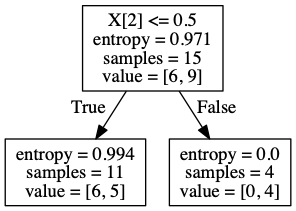

In [41]:
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image, display
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Create a string buffer to write to (a fake text file)
f = StringIO()

# Write the tree description data to the file
tree.export_graphviz(clf, out_file=f, proportion=False)

# Produce a visulation from the file
graph = pydotplus.graph_from_dot_data(f.getvalue())

display(Image(graph.create_png()))

### Saving your tree image to a file

In [11]:
# Write visualisation to image file 
graph.write_png("decision_tree.png")

True

## Business Example<a id='example'></a>

Let's take a look at how you could use a decision tree to determine if someone will default on their loan or not

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### data loading and processing

In [45]:
default = pd.read_csv("default.csv")

default = pd.get_dummies(default)

y = default['default']
X = default.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

**Question:**
how to check how many default samples vs not default samples do we have?

### model building
You may have noticed that in this dataset there are very few cases where people default on their loans (most people pay their loans). So we can <span class="girk">weight the default class more</span> to improve classification results.

Also we set the depth to 5 layers.

In [46]:
default_clf = tree.DecisionTreeClassifier(max_depth = 5, 
                                          class_weight = 'balanced')

default_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### visualise the tree

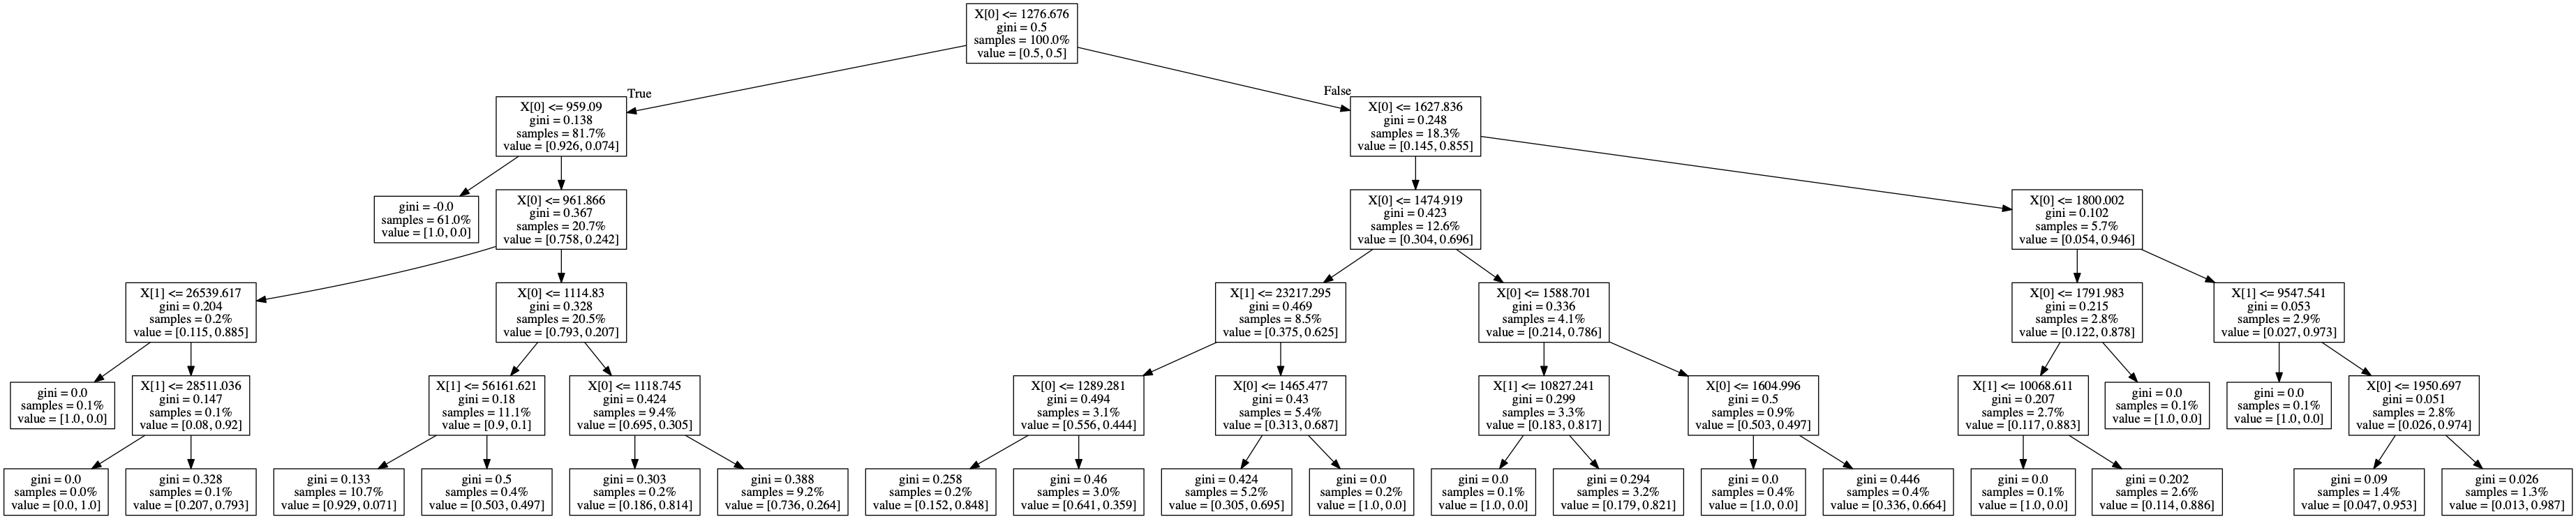

In [48]:
# Create a string buffer to write to (a fake text file)
f = StringIO()

# Write the tree description data to the file
tree.export_graphviz(default_clf, out_file=f, proportion=True)

# Produce a visulation from the file
graph = pydotplus.graph_from_dot_data(f.getvalue())

display(Image(graph.create_png()))

In [16]:
# Write visualisation to image file 
graph.write_png("decision_tree_default.png")

True

### check the prediction accuracy

In [17]:
y_pred = default_clf.predict(X_test)

print("Number of defaults in test set: {0}".format(sum(y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Number of defaults in test set: 96
[[2109  295]
 [  16   80]]
             precision    recall  f1-score   support

          0       0.99      0.88      0.93      2404
          1       0.21      0.83      0.34        96

avg / total       0.96      0.88      0.91      2500



## Discussion 

Like other methods you have already learnt about, decision trees have hyper parameters. The main parameter is the <span class="girk">tree depth</span>. You can try increase or decreasing the tree depth to see how it affects classification results.

**To pick the optimal depth you should use <span class="mark">cross validation</span>.**

The <span class="girk">number of samples</span> from each class also plays a roll in the success of our tree. I have shown you how you can apply more favourable weighting to a smaller class using the "balanced" class_weights option. How you weight your classes depends also on the application. In some areas you would prefer to be more conservative, i.e. prefer false positives rather than false negatives, for example in diagnosing patients or lending money. Your weighting scheme should reflect this.

## Installing Graphviz and Pydotplus<a id='graphviz'></a>

For this tutorial, you will need to install two libraries to visualise decison trees:
- graphviz
- pydotplus

### Windows:
1. Download and install graphviz http://www.graphviz.org/pub/graphviz/stable/windows/graphviz-2.38.msi
2. Add graphviz to your PATH environment variable
    1. Go to Computer > Properties > Advanced system settings> Environment Variables and then find "Path" in the system variables box. Click on Path and click edit.
    2. Append "C:\ProgramFiles(x86)\Graphviz2.38\bin" to the end of the many paths that are already present in Path.
3. Type the following commands on windows command prompt
    1. pip install graphviz
    2. conda install -c conda-forge pydotplus

If you see error "pip is not recognized as an internal or external command" when using "pip", you may refer to the following video.
http://mycodingzone.net/blogpost/english/pip-is-not-recognized-as-an-internal-or-external-command

If you see error "conda is not recognized as an internal or external command" when using "pip", refer to the document attached in tutorial material to see how to use Anaconda command promot to run "conda"

If you see error "InvocationException: GraphViz's executables not found", you may run below code in Python:

import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


### Mac OS X:
1. Type the following on the terminal
    1. pip install graphviz
    2. conda install graphviz
    3. conda install -c conda-forge pydotplus